In [1]:
import pandas as pd               
import numpy as np
import math

In [2]:
import spiceypy as sp
import astropy.coordinates
import re
import sgp4.api as sg
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
import matplotlib.pyplot as plt
import os
import sys
from timeit import default_timer as timer
from astropy.time import Time
from astropy.time import TimeDelta
import datetime as dt

#### Let us start with reading in the first 10000 LSST observations for Main Belt Asteroids (S1 in the Synthetic Solar System model)

In [4]:
path = "/data/projects/lsst/baseline_fbs_v1p7p1/"
dir_list = os.listdir(path)

dflist=[]

for d in dir_list:
    if(d[0:2]=='S1'):
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0000000.h5'))
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0010000.h5'))

In [5]:
# every dataframe looks like this
dflist[0]

,ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),...,MaginFilterTrue,AstrometricSigma(mas),PhotometricSigma(mag),SNR,AstrometricSigma(deg),MaginFilter,dmagDetect,AstRATrue(deg),AstDecTrue(deg),filter
211,S1005COHa,8587,59865.021493,2.690753e+08,13.782810,340.818744,-0.095850,-7.472619,-0.013669,3.928341e+08,...,19.468831,10.696579,0.005886,183.966858,0.000003,19.465719,0.003215,340.818741,-7.472622,r
546,S1005CXma,5510,59861.138563,4.454802e+08,18.662921,327.614280,-0.045996,-17.407163,0.017972,5.029721e+08,...,22.467690,90.460293,0.180959,5.513790,0.000025,22.383414,0.001497,327.614256,-17.407186,z
1203,S1005DbNa,3421,59858.266303,2.911199e+08,-2.884087,29.040982,-0.170618,-0.066137,-0.124001,4.004475e+08,...,22.321059,112.979378,0.219621,4.460532,0.000031,22.105486,0.028190,29.040965,-0.066202,y
1299,S1005Ddta,9138,59865.290202,2.112398e+08,-1.127916,31.217419,-0.259774,5.339466,-0.071889,3.204824e+08,...,19.024007,12.785436,0.016855,63.918065,0.000004,19.053602,0.043812,31.217421,5.339464,y
2116,S1005Dyza,8654,59865.054790,3.644915e+08,21.046205,319.284823,0.027663,-7.971674,-0.009323,4.144269e+08,...,22.678947,27.121781,0.042784,24.880463,0.000008,22.704115,0.000359,319.284810,-7.971661,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476169,S1005khoa,2362,59857.171250,3.165510e+08,10.602041,345.841875,-0.170822,-8.606697,-0.007663,4.500491e+08,...,20.367995,24.692837,0.044988,23.637483,0.000007,20.374396,0.016343,345.841879,-8.606696,y
1476657,S1005kpIa,7151,59863.120770,4.141916e+08,24.719844,319.797276,0.021937,-31.362545,0.075049,4.126039e+08,...,21.724321,35.525918,0.065486,16.084679,0.000010,21.881854,0.003293,319.797278,-31.362536,i
1476660,S1005kpIa,7184,59863.137163,4.142266e+08,24.751666,319.797651,0.022363,-31.361289,0.075284,4.126185e+08,...,21.717580,35.489650,0.074790,14.022869,0.000010,21.718822,0.004291,319.797641,-31.361304,z
1476940,S1005kwia,7710,59863.992235,4.046265e+08,23.371508,311.638323,0.069374,-8.463460,-0.083847,4.076687e+08,...,22.609969,88.901803,0.104647,9.883230,0.000025,22.698784,0.002677,311.638298,-8.463429,r


In [6]:
# concatenate them into a single dataframe
dfin=pd.concat(dflist)

In [7]:
# we can sort the resulting dataframe by by FieldID
dfin.sort_values(['FieldID'], inplace=True)

In [8]:
# then grouping and counting is a little faster. It seems that FieldID 0 has the most observations
dfin.groupby(['FieldID']).count()['ObjID']

FieldID
0        390
1        363
2        164
3         96
4         77
        ... 
19992      3
19993      1
19996      2
19998      3
19999      1
Name: ObjID, Length: 16608, dtype: int64

In [9]:
def icrf2radec(pos, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        r=norm(pos,axis=1)
        xu=pos[:,0]/r
        yu=pos[:,1]/r
        zu=pos[:,2]/r
    else:
        r=norm(pos)
        xu=pos[0]/r
        yu=pos[1]/r
        zu=pos[2]/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec

In [10]:
def radec2icrf(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
    
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)
    
    return array([x, y, z])

In [11]:
field_ids = dfin['FieldID'].unique()

In [12]:
dates = dfin['FieldMJD'].unique()

In [13]:
print("Earliest field date: " + str(min(dates)) + " or 10-01-2022 at 23:39:19.663 UTC")
print("Last field date: " + str(max(dates)) + " or 10-30-2022 at 05:03:20.104 UTC")

Earliest field date: 59853.98564424414 or 10-01-2022 at 23:39:19.663 UTC
Last field date: 59882.21064935192 or 10-30-2022 at 05:03:20.104 UTC


In [14]:
with open('starlink tle.txt') as f:
    starlinks = f.read().splitlines() 

In [15]:
chunks = [starlinks[n:n + 3] for n in range(0, len(starlinks), 3)]

In [16]:
chunks

[['STARLINK-24             ',
  '1 44238U 19029D   21237.86036098  .00007126  00000-0  37494-3 0  9993',
  '2 44238  52.9979  31.4542 0001740 103.9964 256.1222 15.16678365123214'],
 ['STARLINK-61             ',
  '1 44249U 19029Q   21237.61543563  .00009867  00000-0  43787-3 0  9994',
  '2 44249  52.9845   4.5063 0002069 294.3150  65.7629 15.22189982125322'],
 ['STARLINK-71             ',
  '1 44252U 19029T   21237.87426977  .00008416  00000-0  41478-3 0  9999',
  '2 44252  52.9989  32.1716 0002375 104.2717 255.8541 15.18750496123844'],
 ['STARLINK-43             ',
  '1 44257U 19029Y   21238.10491661  .00042073  00000-0  81370-3 0  9995',
  '2 44257  52.9970 267.2434 0002357  52.3365 307.7855 15.47360066126726'],
 ['STARLINK-70             ',
  '1 44281U 19029AY  21237.87370611  .00171460  00000-0  13610-2 0  9990',
  '2 44281  52.9909 290.5443 0007442  20.1280 340.0028 15.70203708 57431'],
 ['STARLINK-80             ',
  '1 44282U 19029AZ  21237.91594692  .00009603  00000-0  30423-3 

In [17]:
print("There are " + str(len(chunks)) + " satellites")

There are 1653 satellites


In [18]:
import warnings

In [19]:
def bearing(lat1, long1, lat2, long2):
    '''
    Finds the bearing from one (latitude, longitude) point to another
    
    Parameters:
    -----------
    lat1, long1 ... real [rad]: Initial point
    lat2, long2 ... real [rad]: End point
    
    Returns:
    --------
    bear ... real [rad]: Bearing    
    '''
    
    b2 = np.sin(long2-long1) * np.cos(lat2)
    b1 = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1)
    bear = np.arctan2(b2, b1)
    
    return bear
    
    
def cross_track_distance(lat1, long1, lat2, long2, lat3, long3):
    '''
    Finds the cross track distance from a point to line
    
    Parameters:
    -----------
    lat1, long1 ... real [rad]: Initial point of line
    lat2, long2 ... real [rad]: End point of line
    lat3, long3 ... real [rad]: Third point
    
    Returns:
    --------
    dist ... real [rad]: Cross track distance 
    '''
    c1 = SkyCoord(ra=long1*u.radian, dec=lat1*u.radian, frame='icrs')  # First point
    c2 = SkyCoord(ra=long3*u.radian, dec=lat3*u.radian, frame='icrs')  # Third point

    sep = c1.separation(c2)
    
    bear_1_3 = bearing(lat1, long1, lat3, long3)
    bear_1_2 = bearing(lat1, long1, lat2, long2)

    dist = np.arcsin(np.sin(sep.radian) * np.sin((bear_1_3) - bear_1_2))
    
    return dist


Could not propagate STARLINK-70


Could not propagate STARLINK-76



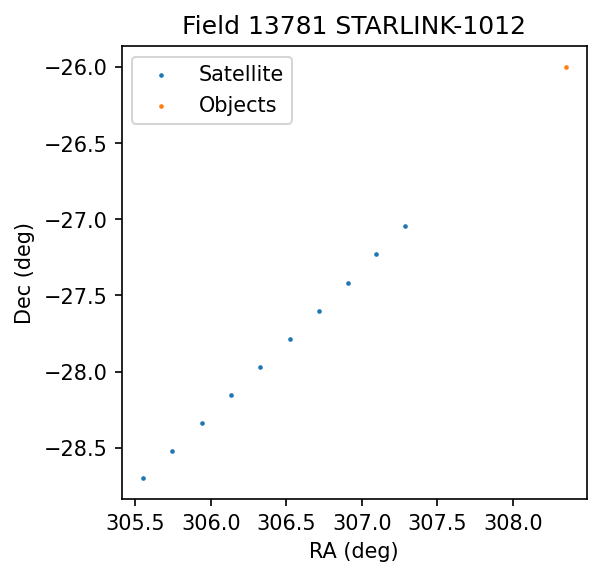

Number of objects affected: 1

Satellite times:
[59873.009747394484, 59873.00977054263, 59873.009793690784, 59873.00981683893, 59873.00983998708, 59873.00986313523, 59873.00988628338, 59873.00990943152, 59873.00993257967, 59873.00995572782]


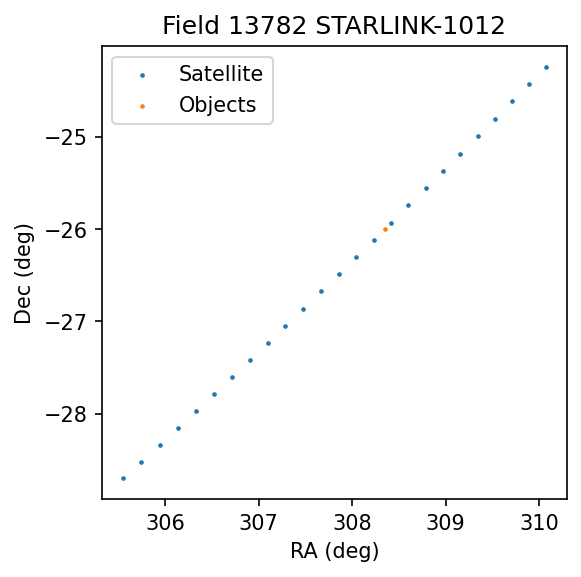

Number of objects affected: 1

Satellite times:
[59873.009747394484, 59873.00977054263, 59873.00979369078, 59873.00981683892, 59873.00983998708, 59873.00986313522, 59873.00988628337, 59873.009909431516, 59873.00993257967, 59873.009955727815, 59873.00997887596, 59873.01000202411, 59873.01002517226, 59873.01004832041, 59873.010071468554, 59873.0100946167, 59873.010117764854, 59873.010140913, 59873.01016406115, 59873.01018720929, 59873.010210357446, 59873.01023350559, 59873.01025665374, 59873.01027980189, 59873.01030295004]


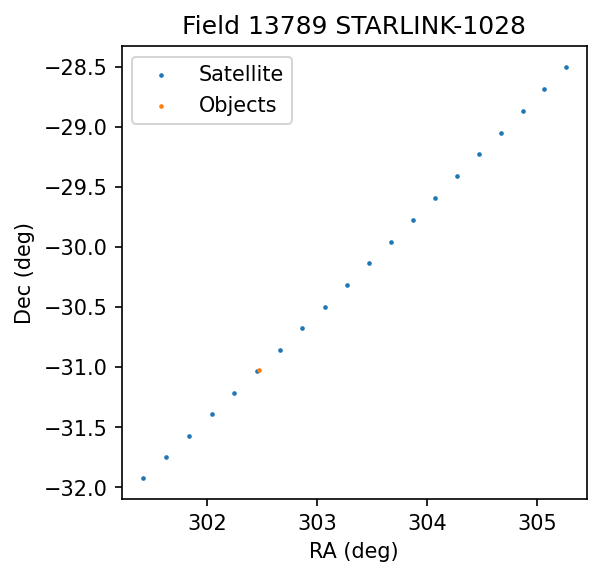

Number of objects affected: 1

Satellite times:
[59873.013075074705, 59873.01309822285, 59873.013121371, 59873.01314451915, 59873.0131676673, 59873.01319081544, 59873.01321396359, 59873.01323711174, 59873.01326025989, 59873.013283408036, 59873.01330655618, 59873.013329704336, 59873.01335285248, 59873.01337600063, 59873.013399148775, 59873.01342229693, 59873.013445445074, 59873.01346859322, 59873.013491741374, 59873.01351488952]


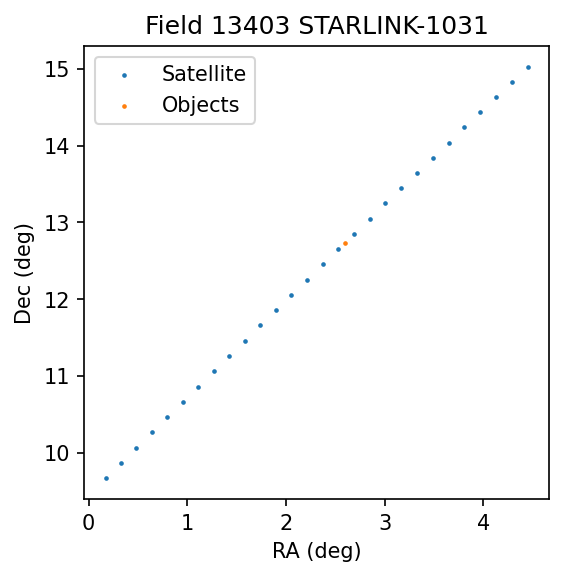

Number of objects affected: 1

Satellite times:
[59871.21351548074, 59871.21353862889, 59871.21356177703, 59871.21358492518, 59871.21360807333, 59871.21363122148, 59871.213654369625, 59871.21367751777, 59871.213700665925, 59871.21372381407, 59871.21374696222, 59871.213770110364, 59871.21379325852, 59871.213816406664, 59871.21383955481, 59871.213862702956, 59871.21388585111, 59871.213908999256, 59871.2139321474, 59871.21395529555, 59871.2139784437, 59871.21400159185, 59871.214024739995, 59871.21404788814, 59871.214071036295, 59871.21409418444, 59871.21411733259, 59871.21414048073]


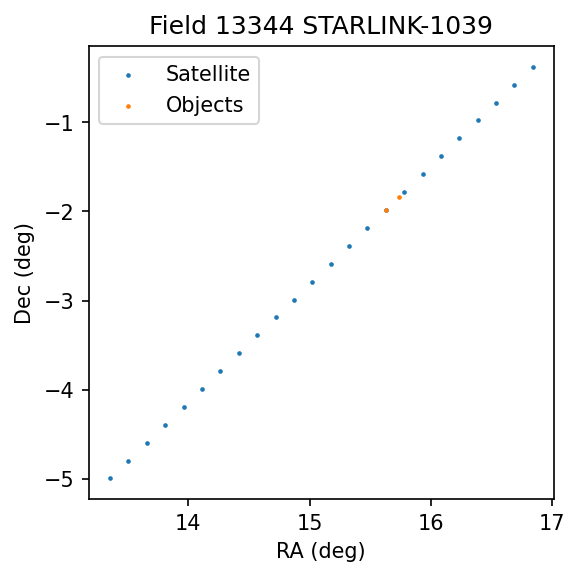

Number of objects affected: 2

Satellite times:
[59871.18571586814, 59871.185739016284, 59871.18576216444, 59871.185785312584, 59871.18580846073, 59871.18583160888, 59871.18585475703, 59871.185877905176, 59871.18590105332, 59871.18592420147, 59871.18594734962, 59871.18597049777, 59871.185993645915, 59871.18601679406, 59871.186039942215, 59871.18606309036, 59871.18608623851, 59871.186109386654, 59871.18613253481, 59871.18615568295, 59871.1861788311, 59871.186201979246, 59871.1862251274, 59871.186248275546]

Could not propagate STARLINK-1044



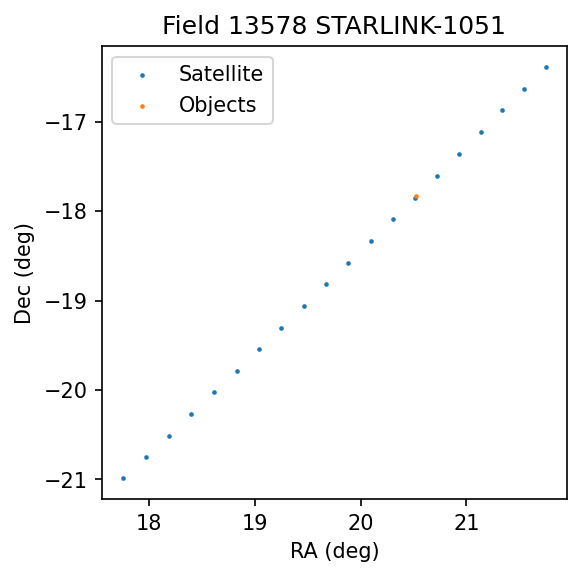

Number of objects affected: 1

Satellite times:
[59871.29772890037, 59871.297752048515, 59871.29777519667, 59871.297798344815, 59871.29782149296, 59871.29784464111, 59871.29786778926, 59871.29789093741, 59871.29791408555, 59871.2979372337, 59871.29796038185, 59871.29798353, 59871.298006678146, 59871.29802982629, 59871.298052974445, 59871.29807612259, 59871.29809927074, 59871.298122418884, 59871.29814556704, 59871.298168715184]


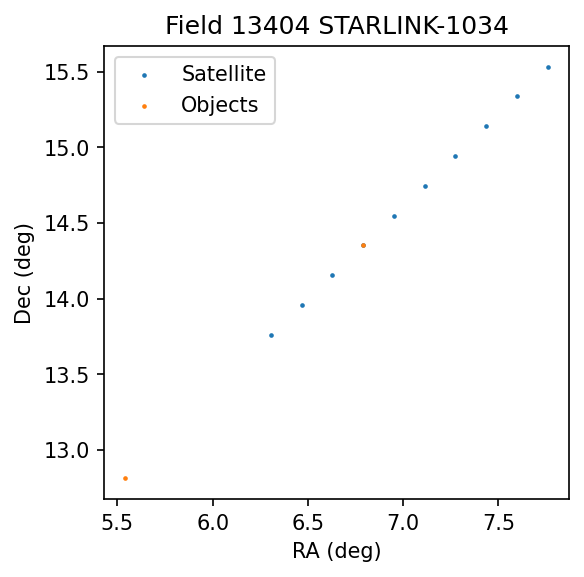

Number of objects affected: 2

Satellite times:
[59871.213566956154, 59871.2135901043, 59871.213613252454, 59871.2136364006, 59871.21365954875, 59871.21368269689, 59871.213705845046, 59871.21372899319, 59871.21375214134, 59871.213775289485]


In [27]:
warnings.filterwarnings('ignore')

for ch in chunks:
    sat_num = ch[0].strip()  # STARLINK-xx
    s = ch[1]
    t = ch[2]
    sat = sg.Satrec.twoline2rv(s, t)  # check each satellite against each field
    
    flag_2 = False

    if flag_2:
        continue
                
    for f in field_ids:
        ra_vals = []  # for satellites
        dec_vals = []  # for satellites
        sat_times = []
        
        data = dfin[dfin['FieldID']==f]  # all objects in the field

        ra_f = data['AstRA(deg)']  # RA of all objects
        dec_f = data['AstDec(deg)']  # Dec of all objects
                
        min_ra, max_ra = min(ra_f), max(ra_f)
        min_dec, max_dec = min(dec_f), max(dec_f)

        mjd_t = data['FieldMJD'].unique()[0]  # field time
        
        t = Time(mjd_t, format='mjd')  # convert to Time format
        t_change = TimeDelta(2.0, format='sec')
        
        flag = False
        
        count = 1
        
        # Propagate every 2.0 sec starting 30 sec before field time until 30 sec after
        t_before = t - TimeDelta(30.0, format='sec')
        
        while count <= 61:
            jd_t = t_before + 2400000.5  # convert mjd to jd for sgp4 calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = stuff after decimal
    
            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))
            x, y, z = r[0], r[1], r[2]
            length = np.sqrt(x**2 + y**2 + z**2)
            norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
            ra, dec = icrf2radec(norm_coords)  # convert to ra and dec
            
            if ra != ra:  # if nan (sat can't be propagated)
                flag = True
                break  # don't bother looking at all the times in while loop

            if (min_ra - 1.0 <= ra <= max_ra + 1.0) and (min_dec - 1.0 <= dec <= max_dec + 1.0):
                ra_vals.append(ra)
                dec_vals.append(dec)
                sat_times.append(t_before.value)
    
            t_before += t_change
            count += 1
            
        if flag:
            print()
            print("Could not propagate " + sat_num)
            print()
            flag_2 = True
            break  # break out of for loop of the fields, go to next satellite
            
            
        # only successful satellite points
        if any(ra_vals):
            good_obj_ra, good_obj_dec = [], []
            
            obj_count = 0
            
            # for satellites
            min_ra, max_ra = min(ra_vals), max(ra_vals)
            min_dec, max_dec = min(dec_vals), max(dec_vals)
            
            min_long, max_long = np.deg2rad(min_ra), np.deg2rad(max_ra)
        
            min_lat, max_lat = np.deg2rad(min_dec), np.deg2rad(max_dec)        

            for obj_r, obj_d in zip(ra_f, dec_f):
                obj_long = np.deg2rad(obj_r)
                obj_lat = np.deg2rad(obj_d)

                dist = cross_track_distance(min_lat, min_long, max_lat, max_long, obj_lat, obj_long)
                bound_d = 2.0 * np.pi/(180*3600)  # 2 arcseconds in radians
                
                if abs(dist) <= bound_d:
                    good_obj_ra.append(obj_r)
                    good_obj_dec.append(obj_d)
                    obj_count += 1
                    
            # only successful object points 
            if any(good_obj_ra):
                plt.figure(dpi=150,figsize=(4,4))
                plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite')
                plt.scatter(good_obj_ra, good_obj_dec, s=1.5, label='Objects')
                title = "Field " + str(f) + " " + sat_num
                plt.title(title)
                plt.xlabel('RA (deg)')
                plt.ylabel('Dec (deg)')
                plt.legend()
#                 plt.savefig(title)
                plt.show()

                print("Number of objects affected: " + str(obj_count))
                print()
                print("Satellite times:")
                print(str(sat_times))
#                 print(str(sat_times)[1:-1])  # remove brackets from list output

In [21]:
cross_track_distance(0, 0, np.pi/4, 0, 0, np.pi/4)

0.7853981633974482

In [22]:
cross_track_distance(0, 0, np.pi/4, 0, np.pi/4, 0)

0.0